In [1]:
# import libraries
import sys
from statsbombpy.api_client import get_resource
import statsbombpy
from statsbombpy import sb
from datetime import datetime
import pandas as pd
import vector_angle
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import os, json
from season_utils import season
from time import sleep
from scipy import stats
from functools import reduce
import numpy as np
import requests
import urllib
## Cell computation timer
%load_ext autotime

# Declaring credentials
credentials={'user':'vignesh.jayanth@staderennais.fr','passwd':'7XtHANc7'}

time: 391 µs (started: 2021-10-28 09:28:59 +02:00)


In [59]:
### Enter Token, Possession type & get Competition Details below from season schedule ###
g=season()
season_schedule=g.season_schedule()
comps=season_schedule['id'].astype(int)
possession_type=['all','tip','otip']

skc1=pd.read_csv('/Users/vignesh.jayanth/env/lib/python3.8/site-packages/Physical_Visualization/Files/All_leagues_Players1.csv')
skc1=pd.merge(skc1,season_schedule,on='id',how='left')

skc2=pd.read_csv('/Users/vignesh.jayanth/env/lib/python3.8/site-packages/Physical_Visualization/Files/All_leagues_Players.csv')
skc2 = skc2.drop(columns=['season_name', 'season_id'])

skc2=pd.merge(skc2,season_schedule,on='id',how='left')

skc=skc1.append(skc2)
skc=skc.rename(columns={'player_birthdate': 'birth_date','date':'match_date','league_name':'competition'})
skc['match_id']=skc['match_id'].astype(int)

skc["competition"]=skc["competition"].str.strip()

skc["competition"]=skc["competition"].str.rsplit("-", 1).str[0]
skc["competition"]=skc["competition"].str.strip()


skc2 = skc.drop(columns=['team','League_Id',
                          'Unnamed: 0','competition_id', 'competition_edition_id'])

skc2=skc2.rename(columns={'team_name': 'Team','competition':'League','group':'Position_Group_SKC',
                          'match_name':'Match','match_date':'Date','position':'Position_SKC','birth_date':'Birth_date',
                          'player_name':'Player_SKC'})

skc2.drop_duplicates(subset =['Player_SKC','Date'],
                     keep = 'last', inplace = True)

check1 = skc2.groupby(['League', 'Team']).size().reset_index(name='Freq')
del check1['Freq']
check1.to_excel('/Users/vignesh.jayanth/Documents/teams_skc.xlsx')

cols = ['Player_SKC','Team','Match','League','Position_SKC','Position_Group_SKC','Birth_date','Season',
        'Date','Minutes', 'Distance', 'Running Distance', 'HSR Distance',
    'Sprinting Distance', 'Count HSR', 'Count Sprint', 'Count Acceleration',
    'Count Deceleration', 'Minutes TIP', 'Distance TIP','PSV-99',
    'Running Distance TIP', 'HSR Distance TIP', 'Sprinting Distance TIP',
    'Count HSR TIP', 'Count Sprint TIP', 'Count Acceleration TIP',
    'Count Deceleration TIP', 'Minutes OTIP', 'Distance OTIP',
    'Running Distance OTIP', 'HSR Distance OTIP', 'Sprinting Distance OTIP',
    'Count HSR OTIP', 'Count Sprint OTIP', 'Count Acceleration OTIP',
    'Count Deceleration OTIP']

skc2=skc2[cols]

skc2=skc2[skc2['Minutes']>=60].reset_index(drop=True)

skc3 = skc2.groupby(['Player_SKC','Team','Season','Match','League','Position_SKC','Position_Group_SKC','Birth_date','Date']).mean()
skc5=skc3[['Minutes','PSV-99']]

def PEC (a, b):
    return a*90 / b if b>90 else a

skc4 = skc3.apply(lambda row : PEC(row, row['Minutes']), axis = 1)

skc4 = skc4.drop(columns=['Minutes', 'PSV-99'])
skc4=pd.merge(skc4,skc5, left_index=True, right_index=True).reset_index()

skc4['HIDistance'] = skc4['HSR Distance'] + skc4['Sprinting Distance']
skc4['HI Count'] = skc4['Count HSR'] + skc4['Count Sprint']

skc4['Mmin'] = skc4["Distance"] / 90 #amended
skc4['HI Mmin'] = skc4['HIDistance'] / 90 #amended
skc4['HI Distance TIP'] = skc4['HSR Distance TIP'] + skc4['Sprinting Distance TIP']
skc4['HI Count TIP'] = skc4['Count HSR TIP'] + skc4['Count Sprint TIP']
skc4['MMin TIP'] = skc4['Distance TIP'] / skc4['Minutes TIP'] #amended

skc4['HI MMin TIP'] = skc4['HI Distance TIP']  / skc4['Minutes TIP'] #amended

skc4['HI Distance OTIP'] = skc4['HSR Distance OTIP'] + skc4['Sprinting Distance OTIP']
skc4['HI Count OTIP'] = skc4['Count HSR OTIP'] + skc4['Count Sprint OTIP']
skc4['MMin OTIP'] = skc4['Distance OTIP'] / skc4['Minutes OTIP'] #amended
skc4['HI MMin OTIP'] = skc4['HI Distance OTIP']  / skc4['Minutes OTIP'] #amended

skc4.columns = skc4.columns.str.replace(' ','_')
skc4.columns = skc4.columns.str.replace('-','_')

match_count=pd.DataFrame(skc4.groupby(['Season','League','Team','Player_SKC'])['Match'].count()).reset_index()
Deep_Mid=['CM','DM']
skc4['Position_Group_SKC']=np.where(skc4['Position_SKC'].isin(Deep_Mid),'Central/Deep Midfielder',skc4['Position_Group_SKC'])



time: 1min 18s (started: 2021-10-22 12:32:10 +02:00)


In [95]:
# Subset Top 8 Leagues and Champions League # and the positions 

LOI=['ENG - Premier League', 'ITA - Serie A', 'NED - Eredivisie',
       'GER - Bundesliga', 'FRA - Ligue 1','POR - Primeira Liga',
       'BEL - Pro League', 'ESP - LaLiga', 'NED - Eredivisie']

skcx1=skc4[['Season','League','Team','Player_SKC','Position_SKC','Position_Group_SKC','PSV_99']]

# Subsetting the Top 5 Peak Sprint Velocities for Players- Average and Max Sprint Velocity #
skcx_top5=skcx1.groupby(['Season','League','Team','Player_SKC'])['PSV_99'].nlargest(5).reset_index()
skcx_top5=skcx_top5.groupby(['Season','League','Team','Player_SKC'])['PSV_99'].mean().reset_index(name='Top5_avg_PSV99')


# Subsetting Max Sprint Velocity #
skcx_max=skcx1.groupby(['Season','League','Team','Player_SKC'])['PSV_99'].nlargest(1).reset_index(name='max_PSV99')

# Averaging the players  #
skcx = skc4.groupby(['Season','League','Team','Player_SKC','Position_Group_SKC']).mean().reset_index()

skcx=pd.merge(skcx,match_count,on=['Season','League','Team','Player_SKC'],how='left')
skcx=pd.merge(skcx,skcx_top5,on=['Season','League','Team','Player_SKC'],how='left')
skcx=pd.merge(skcx,skcx_max,on=['Season','League','Team','Player_SKC'],how='left')


skcx=skcx[(skcx['League'].isin(LOI)) &
         (skcx['Match']>=5)].reset_index(drop=True)
skcx[['Season_start','Season_end']]=skcx['Season'].str.split('-', 1, expand=True)

skcx.set_index(['Season','Team','Player_SKC','League','Position_Group_SKC','Season_start'], inplace=True)
TIP_cols = skcx.filter(regex='_TIP').columns
OTIP_cols = skcx.filter(regex='OTIP').columns
PSV_cols = skcx.filter(regex='PSV').columns
TIP_skc4=skcx[TIP_cols]
OTIP_skc4=skcx[OTIP_cols]
PSV_skc4=skcx[PSV_cols]


# Subset all the TIP columns #

Q1 = TIP_skc4.quantile(0.25)
Q3 = TIP_skc4.quantile(0.75)
IQR = Q3 - Q1

# Subset all the OTIP columns #

Q11 = OTIP_skc4.quantile(0.25)
Q31 = OTIP_skc4.quantile(0.75)
IQR1 = Q31 - Q11

# Subset all the PSV columns #

Q12 = PSV_skc4.quantile(0.25)
Q32 = PSV_skc4.quantile(0.75)
IQR2 = Q32 - Q12


# Remove outliers for when team in possession #
subset_TIP_skc4 = TIP_skc4[~((TIP_skc4 < (Q1 - 1.5 * IQR)) |(TIP_skc4 > (Q3 + 1.5 * IQR))).any(axis=1)]
subset_OTIP_skc4=subset_OTIP_skc4.reset_index()

# Remove outliers for when team not in possession #
subset_OTIP_skc4 = OTIP_skc4[~((OTIP_skc4 < (Q11 - 1.5 * IQR)) |(OTIP_skc4 > (Q31 + 1.5 * IQR))).any(axis=1)]
subset_TIP_skc4=subset_TIP_skc4.reset_index()

# Remove outliers for speed - PSV 99 #
PSV_99_skc4 = PSV_skc4[~((PSV_skc4 < (Q12 - 1.5 * IQR)) |(PSV_skc4 > (Q32 + 1.5 * IQR))).any(axis=1)]


time: 2min 27s (started: 2021-10-22 15:41:19 +02:00)


<ipython-input-95-8c2646194cac>:62: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  subset_OTIP_skc4 = OTIP_skc4[~((OTIP_skc4 < (Q11 - 1.5 * IQR)) |(OTIP_skc4 > (Q31 + 1.5 * IQR))).any(axis=1)]
<ipython-input-95-8c2646194cac>:62: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  subset_OTIP_skc4 = OTIP_skc4[~((OTIP_skc4 < (Q11 - 1.5 * IQR)) |(OTIP_skc4 > (Q31 + 1.5 * IQR))).any(axis=1)]
<ipython-input-95-8c2646194cac>:66: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  PSV_99_skc4 

# Team in Possession #

In [138]:
# Importing the Rankings Info #

Rankings=pd.read_excel('/Users/vignesh.jayanth/Documents/team_info.xlsx')

# Importing the Team Matched Names #
Matched_teams=pd.read_excel('/Users/vignesh.jayanth/Documents/Physical and Technical Data Combined/skc_rapid_api_team_mapping.xlsx')

# Rankings of Teams #
Rankings=pd.merge(Rankings,Matched_teams[['matches','Team']],left_on='team_name',right_on='matches',how='left')

# Pick necessary columns #

Rankings=Rankings[['rank', 'points','Team','league_season']]

Rankings['league_season']=Rankings['league_season'].astype(str)

subset_TIP_skc41=subset_TIP_skc4[subset_TIP_skc4['Season_start']!='2016']

subset_TIP_skc4x=pd.merge(subset_TIP_skc41,Rankings,left_on=['Team','Season_start'],right_on=['Team','league_season'],how='left')

Rank_groups = ['1-4', '5-7', '8-10', '11-20']
cut_bins = [0, 4, 7, 10, 20]
subset_TIP_skc4x['Rank_groups'] = pd.cut(subset_TIP_skc4x['rank'], bins=cut_bins, labels=Rank_groups)

# Keep only two seasons of Data # - Check for a specific position

seasons=['2019-2020','2020-2021']

subset_TIP_skc4x1=subset_TIP_skc4x[subset_TIP_skc4x['Season'].isin(seasons)].reset_index(drop=True)
subset_TIP_skc4x2=subset_TIP_skc4x1[subset_TIP_skc4x1['Position_Group_SKC']=='Winger'].reset_index(drop=True)


time: 493 ms (started: 2021-10-22 16:59:58 +02:00)


In [143]:
# What is the difference between the metrics between each of the positions- is it alot? 

subset_TIP_skc4x1=subset_TIP_skc4x1.groupby(['League','Position_Group_SKC','Rank_groups']).mean()
Rankingsx_zscore=subset_TIP_skc4x1.apply(zscore)

ranks=Rankingsx_zscore.rank(ascending=False)
ranks=ranks.reset_index()

ranks = ranks.drop(columns=['rank','points'])

ranks


League       Position_Group_SKC Rank_groups  Minutes_TIP  \
0       BEL - Pro League         Central Defender         1-4         16.0   
1       BEL - Pro League         Central Defender         5-7         38.0   
2       BEL - Pro League         Central Defender        8-10         45.0   
3       BEL - Pro League         Central Defender       11-20         83.0   
4       BEL - Pro League  Central/Deep Midfielder         1-4         52.0   
..                   ...                      ...         ...          ...   
187  POR - Primeira Liga                 Midfield       11-20        185.0   
188  POR - Primeira Liga                   Winger         1-4         70.0   
189  POR - Primeira Liga                   Winger         5-7        168.0   
190  POR - Primeira Liga                   Winger        8-10        191.0   
191  POR - Primeira Liga                   Winger       11-20        190.0   

     Distance_TIP  Running_Distance_TIP  HSR_Distance_TIP  \
0           104.0                 169.0             169.0   
1           130.0                 167.0             158.0   
2           125.0                 173.0             163.0   
3           155.0                 177.0             172.0   
4            19.0                  36.0             131.0   
..            ...                   ...               ...   
187         147.0                  85.0             128.0   
188          37.0                  23.0               3.0   
189         153.0                  97.0              55.0   
190         182.0                 126.0              59.0   
191         180.0                 129.0              63.0   

     Sprinting_Distance_TIP  Count_HSR_TIP  Count_Sprint_TIP  \
0                     162.0          175.0             160.0   
1                     164.0          165.0             153.0   
2                     154.0          171.0             154.0   
3                     157.0          177.0             155.0   
4                     130.0          136.0             129.0   
..                      ...            ...               ...   
187                   128.0          130.0             127.0   
188                     5.0           26.0               9.0   
189                    49.0           63.0              48.0   
190                    57.0           64.0              43.0   
191                    44.0           65.0              38.0   

     Count_Acceleration_TIP  Count_Deceleration_TIP  HI_Distance_TIP  \
0                     140.0                   134.0            167.0   
1                     161.0                   155.0            157.0   
2                     169.0                   160.0            161.0   
3                     177.0                   162.0            168.0   
4                     106.0                   103.0            129.0   
..                      ...                     ...              ...   
187                   168.0                   161.0            128.0   
188                    24.0                    35.0              3.0   
189                   123.0                    79.0             52.0   
190                   147.0                   105.0             56.0   
191                   158.0                   100.0             59.0   

     HI_Count_TIP  MMin_TIP  HI_MMin_TIP  
0           173.0     185.0        177.0  
1           164.0     176.0        159.0  
2           170.0     168.0        165.0  
3           176.0     164.0        166.0  
4           132.0      77.0        134.0  
..            ...       ...          ...  
187         128.0      12.0        118.0  
188          20.0      67.0         18.0  
189          61.0      69.0         33.0  
190          62.0      36.0          6.0  
191          65.0      37.0         16.0  

[192 rows x 16 columns]

time: 40 ms (started: 2021-10-22 17:05:49 +02:00)


In [134]:
# What is the difference between the teams in each of the leagues- is it alot? 

league_diff=subset_TIP_skc4x2.copy()

league_diff = league_diff.drop(columns=['Season','Season_start','Position_Group_SKC',
                                             'league_season','Team','Player_SKC','rank','points'])

league_diff1=league_diff.groupby(['League','Rank_groups']).mean()

import seaborn as sns

corr=league_diff1.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

time: 66.7 ms (started: 2021-10-22 16:52:08 +02:00)


In [ ]:
Rankingsx_zscore=league_diff1.apply(zscore)
columns=Rankingsx_zscore.columns

ranks=Rankingsx_zscore.rank(ascending=False)
ranks=ranks.reset_index()
Rankingsx_zscore=Rankingsx_zscore.reset_index()

In [123]:
# Which metric has the most variance between top ranked teams and lower ranked teams ?


time: 227 µs (started: 2021-10-22 16:21:50 +02:00)


In [67]:
Rankingsx_zscore=Rankingsx1.apply(zscore)
columns=Rankingsx_zscore.columns


Rankingsx_zscore_rating = pd.DataFrame(scaler.fit_transform(Rankingsx_zscore)*100)
Rankingsx_zscore_rating.columns=columns
Rankingsx_zscore=Rankingsx_zscore.reset_index()
Rankingsx_zscore=Rankingsx_zscore[['Season','League','Team','Rank_groups','rank','Position_Group_SKC']]
Rankingsx_zscore_rating=pd.merge(Rankingsx_zscore_rating, Rankingsx_zscore, left_index=True, right_index=True)
Rankingsx_zscore_rating.to_excel('/Users/vignesh.jayanth/Documents/Rankingsx_zscore_rating.xlsx')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

time: 28.2 ms (started: 2021-10-22 12:51:41 +02:00)


In [10]:
Rankingsx_zscore

Season                        League            Team Rank_groups  \
0    2017-2018       Germany - 1. Bundesliga   Bayern Munich         1-4   
1    2018-2019              France - Ligue 1       AS Monaco       11-20   
2    2018-2019       Germany - 1. Bundesliga   Bayern Munich         1-4   
3    2019-2020  Belgium - Jupiler Pro League        AS Eupen       11-20   
4    2019-2020  Belgium - Jupiler Pro League         Antwerp         1-4   
..         ...                           ...             ...         ...   
376  2021-2022               Spain - La Liga         Osasuna         5-7   
377  2021-2022               Spain - La Liga  Rayo Vallecano         5-7   
378  2021-2022               Spain - La Liga      Real Betis        8-10   
379  2021-2022               Spain - La Liga     Real Madrid         1-4   
380  2021-2022               Spain - La Liga   Real Sociedad         1-4   

     rank Position_Group_SKC  
0       1             Winger  
1      17             Winger  
2       1             Winger  
3      13             Winger  
4       4             Winger  
..    ...                ...  
376     5             Winger  
377     6             Winger  
378     8             Winger  
379     2             Winger  
380     1             Winger  

[381 rows x 6 columns]

time: 11.6 ms (started: 2021-10-22 10:48:54 +02:00)


In [8]:
import seaborn as sns

corr=Rankingsx1.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

time: 130 ms (started: 2021-10-22 10:46:34 +02:00)


In [163]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder


# Normalize feature data
scaler = MinMaxScaler()

def contribution_rating(data,name):
    
    data1=data.reset_index()

    X = scaler.fit_transform(data)
    X1=X.T


    Var=[]
    Mean=[]

    for i in X1:
        v=statistics.variance(i)
        m=statistics.mean(i)
        Var.append(v)
        Mean.append(m)


    mean=pd.DataFrame(Mean)
    Var=pd.DataFrame(Var)
    mean=mean.T
    Var=Var.T
    mean=np.array(mean)
    Var=np.array(Var)

    #### Multiply two different columns #####
    X3=(X*mean)

    col=list(data.columns)
    X3=pd.DataFrame(X3)
    X3.columns=col

    # Normalize feature data
    Total= pd.DataFrame(X3.sum(axis=1))
    contribution= pd.DataFrame(scaler.fit_transform(Total)*100).set_axis(['contribution'], axis='columns', inplace=False)
    contribution = contribution.add_prefix(name)
    contribution=pd.merge(data1, contribution, left_index=True, right_index=True)
    
    return contribution

time: 598 ms (started: 2021-10-20 19:48:53 +02:00)


In [49]:
check.to_excel('/Users/vignesh.jayanth/Documents/check.xlsx')


time: 27.5 ms (started: 2021-10-21 14:55:33 +02:00)


In [122]:
import scipy.stats as st

dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
dist_results = []
params = {}
for dist_name in dist_names:
    dist = getattr(st, dist_name)
    param = dist.fit(Rankingsx1)

    params[dist_name] = param
    # Applying the Kolmogorov-Smirnov test
    D, p = st.kstest(Rankingsx1, dist_name, args=param)
    print("p value for "+dist_name+" = "+str(p))
    dist_results.append((dist_name, p))




p value for norm = 0.9985996948136815
p value for exponweib = 0.0006375035109206905
p value for weibull_max = 0.001012962614938663

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1677: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +



p value for weibull_min = 0.001012962614938663
p value for pareto = 0.821036291797699
p value for genextreme = 0.047484730129545905
time: 510 ms (started: 2021-10-20 16:43:53 +02:00)


In [22]:

skcx[['Season_start','Season_end']]=skcx['Season'].str.split('-', 1, expand=True)

# Subset teams to match with team rankings #
teams_skc=skcx[['League','Team']]
teams_skc.drop_duplicates(subset =['League','Team'],keep = 'first', inplace = True)
teams_skc.to_excel('/Users/vignesh.jayanth/Documents/teams_skc.xlsx')


time: 62.4 ms (started: 2021-10-20 10:07:53 +02:00)


<ipython-input-22-a2e81eb2d32d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams_skc.drop_duplicates(subset =['League','Team'],keep = 'first', inplace = True)


In [53]:
Rankings.to_excel('/Users/vignesh.jayanth/Documents/Rankings.xlsx')


time: 7.47 s (started: 2021-10-20 11:23:48 +02:00)


Class=0, n=3646 (19.106%)
Class=3, n=4972 (26.055%)
Class=4, n=3332 (17.461%)
Class=1, n=3557 (18.640%)
Class=2, n=3576 (18.739%)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  # ignore first 'self' argument for instance methods


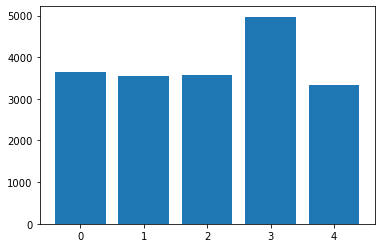

time: 138 ms (started: 2021-10-18 17:49:20 +02:00)


In [362]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE



# split into input and output elements
X= subset_TIP_skc4.iloc[:, 2:]
Y=subset_TIP_skc4[['Position_Group_SKC']]

# Convert the Position Columns to Class Labels #
y = LabelEncoder().fit_transform(Y)
# transform the dataset
scaler = MinMaxScaler()
X = scaler.fit_transform(X)


# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [364]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from numpy import mean
from numpy import std


# define the reference model
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced')
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

time: 2.19 s (started: 2021-10-18 17:49:34 +02:00)


In [365]:
from pycaret.classification import *

clf1 = setup(data = subset_TIP_skc4, target = 'Position_Group_SKC',remove_multicollinearity=True,multicollinearity_threshold=0.7,
            normalize=True,normalize_method='minmax',feature_selection=True,data_split_stratify=True,use_gpu=True)
set_config('seed', 456)


OSError: dlopen(/opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib
  Referenced from: /opt/anaconda3/lib/python3.8/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

time: 5.96 s (started: 2021-10-18 17:53:02 +02:00)


In [350]:
from numpy import mean
from numpy import std

# summarize performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean Accuracy: 0.372 (0.003)
time: 1.53 ms (started: 2021-10-18 17:30:00 +02:00)


In [335]:
y

array([ 5, 10,  7, ..., 10, 11, 13])

time: 1.89 ms (started: 2021-10-18 17:12:02 +02:00)


In [312]:
corr=subset_OTIP_skc4.corr()

cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

time: 232 ms (started: 2021-10-18 16:59:45 +02:00)


In [261]:
corr_df=skc4.corr()
corr_df.to_excel('/Users/vignesh.jayanth/Documents/corr_df.xlsx')


time: 1.12 s (started: 2021-10-18 15:57:47 +02:00)


In [246]:
skc1.position.unique()

array(['RM', 'LM', 'CF', 'LWB', 'RW', 'LCB', 'LW', 'RCB', 'DM', 'AM',
       'RWB', 'RF', 'LF', 'CB', 'CM'], dtype=object)

time: 42.5 ms (started: 2021-10-18 15:35:08 +02:00)


In [211]:


skc5 = skc5.drop(columns=['Player_SKC', 'Team','Season','Match',
                          'Position_Group_SKC','Birth_date', 'Date'])


cols=skc5.columns
cols1=cols[2:]

skc5[cols1] = skc5[cols1].fillna(skc5.groupby('Position_SKC')[cols1].transform('mean'))
#skc6 = skc5.groupby(['League','Position_SKC']).mean().reset_index()


time: 315 ms (started: 2021-10-18 15:12:32 +02:00)


In [247]:
# Check the data for All AM's across all leagues #

AM=skc5[skc5['Position_SKC']=='RWB'].reset_index(drop=True)
AM = AM.drop(columns=['League','Position_SKC'])

AM1=skc5[skc5['Position_SKC']=='RWB'].reset_index(drop=True)
AM1=AM1.set_index(['League','Position_SKC'], inplace=True)


time: 34.9 ms (started: 2021-10-18 15:35:19 +02:00)


In [253]:
AM_var = pd.DataFrame(AM.std()).set_axis(['Variance'], axis=1, inplace=False).reset_index()

time: 3.94 ms (started: 2021-10-18 15:36:19 +02:00)


<AxesSubplot:xlabel='Distance'>

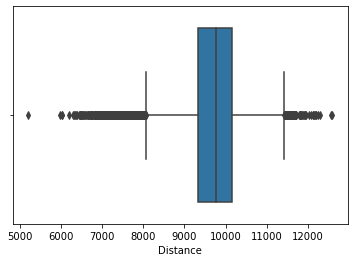

time: 367 ms (started: 2021-10-18 15:43:59 +02:00)


In [255]:
import seaborn as sns
sns.boxplot(x=AM['Distance'])

<BarContainer object of 40 artists>

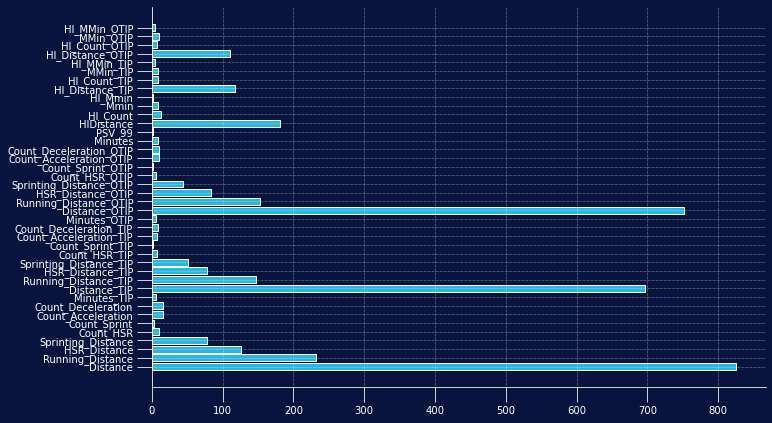

time: 332 ms (started: 2021-10-18 15:36:22 +02:00)


In [254]:
import pandas as pd 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import matplotlib.patheffects as path_effects
import numpy as np
from highlight_text import fig_text

fig,ax = plt.subplots(figsize = (11,7))

#Add grid to the plot
ax.grid(ls="dotted", lw="0.5", color="w", zorder=1)

hfont = {'fontname':'Impact'}

#Change the background color
fig.set_facecolor("#08143D")
ax.patch.set_facecolor("#08143D")

#Change the ticks color
ax.tick_params(axis="x",colors="w", length=15,rotation='auto')
ax.tick_params(axis="y",colors="w", length=15,rotation='auto')


#Change the axes color
ax.spines['bottom'].set_color("w")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color("w")

# Plot Son Goal Involments
plt.barh(AM_var['index'], AM_var['Variance'], zorder=1, color="#2bb6e0",edgecolor = 'w')


In [213]:
AM_var

Distance  Running_Distance  \
League                      Position_SKC                                   
England - Premier League    AM             7467.000000       1113.000000   
Germany - 1. Bundesliga     AM             7693.000000       1636.000000   
England - Premier League    AM             9100.000000       1690.000000   
                            AM            10861.376673       1819.311663   
                            AM             8608.000000       1409.000000   
...                                                ...               ...   
Europe - UEFA Europa League AM             8376.000000       1890.000000   
Portugal - Liga NOS         AM             9404.303848       1326.259421   
                            AM             9443.000000       1528.000000   
                            AM            10042.914480       1242.976227   
                            AM            10285.714286       1679.376623   

                                          HSR_Distance  Sprinting_Distance  \
League                      Position_SKC                                     
England - Premier League    AM              559.000000          336.000000   
Germany - 1. Bundesliga     AM              513.000000           79.000000   
England - Premier League    AM              516.000000           33.000000   
                            AM              733.269598          134.799235   
                            AM              503.000000          164.000000   
...                                                ...                 ...   
Europe - UEFA Europa League AM              478.000000           82.000000   
Portugal - Liga NOS         AM              541.749306          157.973027   
                            AM              484.000000           79.000000   
                            AM              536.276629           53.720284   
                            AM              417.974026           34.597403   

                                          Count_HSR  Count_Sprint  \
League                      Position_SKC                            
England - Premier League    AM            39.000000     17.000000   
Germany - 1. Bundesliga     AM            43.000000      6.000000   
England - Premier League    AM            41.000000      4.000000   
                            AM            58.317400      7.648184   
                            AM            43.000000      5.000000   
...                                             ...           ...   
Europe - UEFA Europa League AM            39.000000      5.000000   
Portugal - Liga NOS         AM            40.162634      8.925030   
                            AM            44.000000      4.000000   
                            AM            35.196048      7.409694   
                            AM            28.051948      6.545455   

                                          Count_Acceleration  \
League                      Position_SKC                       
England - Premier League    AM                     88.000000   
Germany - 1. Bundesliga     AM                     86.000000   
England - Premier League    AM                     92.000000   
                            AM                    118.546845   
                            AM                     84.000000   
...                                                      ...   
Europe - UEFA Europa League AM                     85.000000   
Portugal - Liga NOS         AM                     92.820309   
                            AM                    104.000000   
                            AM                     83.359061   
                            AM                    103.792208   

                                          Count_Deceleration  Minutes_TIP  \
League                      Position_SKC                                    
England - Premier League    AM                    100.000000    14.670000   
Germany - 1. Bundesliga     AM                     89.000000     9.290000   
Eng

time: 31.8 ms (started: 2021-10-18 15:12:39 +02:00)


In [175]:
skc4[['Minutes','Distance','Match','Date','League','Player_SKC']].sort_values(['Distance'], ascending=[False]).head(10)



Minutes      Distance                               Match        Date  \
129501    75.55  13826.000000          Aston Villa v Leeds United  2020-10-23   
240180    93.35  13795.500803                     IK Sirius v AIK  2020-10-29   
155486    90.73  13556.045409  Arsenal Football Club v SL Benfica  2021-02-25   
33335     96.66  13503.724395      FK Bodo/Glimt v Legia Warszawa  2021-07-07   
243534    94.97  13451.195114     FC Barcelona v SK Slavia Prague  2019-11-05   
189707    93.58  13410.557811          FC Barcelona v Inter Milan  2019-10-02   
216799    95.30  13405.561385        FC Barcelona v Villarreal CF  2020-09-27   
293232    94.97  13371.591029     FC Barcelona v SK Slavia Prague  2019-11-05   
164741    95.35  13317.357105    Atlético Madrid v Real Madrid CF  2021-03-07   
178730    98.43  13273.697044    Heracles Almelo v Ajax Amsterdam  2021-02-13   

                             League        Player_SKC  
129501     England - Premier League  Jamie Shackleton  
240180         Sweden - Allsvenskan    Paulos Abraham  
155486  Europe - UEFA Europa League      Julian Weigl  
33335     Europe - Champions League     Bartosz Slisz  
243534    Europe - Champions League       Petr Sevcik  
189707    Europe - Champions League  Marcelo Brozovic  
216799              Spain - La Liga         Moi Gomez  
293232    Europe - Champions League      Tomáš Soucek  
164741              Spain - La Liga              Koke  
178730     Netherlands - Eredivisie     Lucas Schoofs

time: 97.4 ms (started: 2021-10-18 14:50:15 +02:00)


In [48]:
skc4.columns.get_loc("Distance")


9

time: 1.82 ms (started: 2021-10-18 11:21:22 +02:00)


In [22]:
check = player_p90.filter(regex='season')
print(check.columns)



Index(['season'], dtype='object')
time: 8.75 ms (started: 2021-10-18 10:52:10 +02:00)


In [30]:
player_p90.league.unique()

Europe=['Europe - Champions League','Europe - UEFA Europa League']

player_p91=player_p90[player_p90['league'].isin(Europe)].reset_index(drop=True)
print(len(player_p91))

player_p91.set_index(['league','position_sb'], inplace=True)


30798
time: 128 ms (started: 2021-10-18 10:56:00 +02:00)


In [41]:
player_p90.league.unique()

'Russia - Premier League','Scotland - Premier League', 'Europe - Champions League','Europe - UEFA Europa League'

array(['Germany - 1. Bundesliga', 'Portugal - Liga NOS',
       'France - Ligue 1', 'Austria - Bundesliga', 'Spain - La Liga',
       'Ukraine - Premier League', 'Egypt - Premier League',
       'Netherlands - Eredivisie', 'Italy - Serie A',
       'Belgium - Jupiler Pro League', 'France - Ligue 2',
       'England - Premier League', 'Russia - Premier League',
       'Scotland - Premier League', 'Europe - Champions League',
       'Europe - UEFA Europa League'], dtype=object)

time: 29 ms (started: 2021-10-18 10:59:51 +02:00)


In [12]:
player_p91.columns.get_loc("distance")

Index(['id', 'player_match_pressures', 'player_match_long_balls',
       'player_match_shot_touch_ratio', 'player_match_passes_into_box',
       'player_match_pressure_duration_avg', 'player_match_crossing_ratio',
       'player_match_op_f3_forward_passes', 'player_match_passing_ratio',
       'player_match_successful_passes',
       ...
       'mmin', 'hi_mmin', 'hi_distance_tip', 'hi_count_tip', 'mmin_tip',
       'hi_mmin_tip', 'hi_distance_otip', 'hi_count_otip', 'mmin_otip',
       'hi_mmin_otip'],
      dtype='object', length=139)


99

time: 4.46 ms (started: 2021-10-18 10:43:11 +02:00)


In [40]:
df1 = player_p91.iloc[:, 97:]
df2=df1.dropna(axis=0)
df2


distance  \
league                      position_sb                              
Europe - Champions League   Right Wing Back               0.000000   
                            Left Center Forward       11186.724891   
                            Left Center Forward       10910.400000   
                            Right Center Back          9600.316623   
                            Left Center Midfield      11368.583868   
...                                                            ...   
Europe - UEFA Europa League Left Back                     0.000000   
                            Right Center Midfield         0.000000   
                            Left Center Back              0.000000   
                            Right Defensive Midfield      0.000000   
                            Right Center Back             0.000000   

                                                      running_distance  \
league                      position_sb                                  
Europe - Champions League   Right Wing Back                   0.000000   
                            Left Center Forward            1795.283843   
                            Left Center Forward            1941.600000   
                            Right Center Back              1347.862797   
                            Left Center Midfield           2266.498625   
...                                                                ...   
Europe - UEFA Europa League Left Back                         0.000000   
                            Right Center Midfield             0.000000   
                            Left Center Back                  0.000000   
                            Right Defensive Midfield          0.000000   
                            Right Center Back                 0.000000   

                                                      hsr_distance  \
league                      position_sb                              
Europe - Champions League   Right Wing Back               0.000000   
                            Left Center Forward         757.729258   
                            Left Center Forward         652.800000   
                            Right Center Back           402.744063   
                            Left Center Midfield        576.420715   
...                                                            ...   
Europe - UEFA Europa League Left Back                     0.000000   
                            Right Center Midfield         0.000000   
                            Left Center Back              0.000000   
                            Right Defensive Midfield      0.000000   
                            Right Center Back             0.000000   

                                                      sprinting_distance  \
league                      position_sb                                    
Europe - Champions League   Right Wing Back                     0.000000   
                            Left Center Forward               227.947598   
                            Left Center Forward               324.000000   
                            Right Center Back                  95.936675   
                            Left Center Midfield               94.867094   
...                                                                  ...   
Europe - UEFA Europa League Left Back                           0.000000   
                            Right Center Midfield               0.000000   
                            Left Center Back                    0.000000   
                            Right Defensive Midfield            0.000000   
                            Right Center Back                   0.000000   

                                                      count_hsr  count_sprint  \
league                      position_sb                                         
Europe - Champions League   Right Wing Back            0.000000      0.000000   
                            Left Center F

time: 63.5 ms (started: 2021-10-18 10:59:15 +02:00)


In [ ]:
# Normalize feature data
scaler = MinMaxScaler()

def PEC (a, b):
    return a*90 / b if b>45 else a*45 / b

def contribution_rating(data,name):
    
    data1=data.reset_index()

    X = scaler.fit_transform(data)
    X1=X.T


    Var=[]
    Mean=[]

    for i in X1:
        v=statistics.variance(i)
        m=statistics.mean(i)
        Var.append(v)
        Mean.append(m)


    mean=pd.DataFrame(Mean)
    Var=pd.DataFrame(Var)
    mean=mean.T
    Var=Var.T
    mean=np.array(mean)
    Var=np.array(Var)

    #### Multiply two different columns #####
    X3=(X*mean)

    col=list(data.columns)
    X3=pd.DataFrame(X3)
    X3.columns=col

    # Normalize feature data
    Total= pd.DataFrame(X3.sum(axis=1))
    contribution= pd.DataFrame(scaler.fit_transform(Total)*100).set_axis(['contribution'], axis='columns', inplace=False)
    contribution = contribution.add_prefix(name)
    contribution=pd.merge(data1, contribution, left_index=True, right_index=True)
    
    return contribution